In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

# Analysis
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')

# Import Ngl with pyn_env active 
# import Ngl



## Read in data

In [2]:
## Load data rather than re-create (it takes a long time to read it all in) 
saveDir = '/glade/work/mdfowler/CLASP/histData/processedData/'

realSfcHMG_upsample = pickle.load( open( saveDir+"realSfc_HMG_6dayEns00-04_2015-18_30min.p" , "rb") )
realSfcHTG_upsample = pickle.load( open( saveDir+"realSfc_HTG_6dayEns00-04_2015-18_30min.p" , "rb") )

realSfcHMGclm_upsample = pickle.load( open( saveDir+"realSfc_HMGclm_6dayEns00-04_2015-18_30min.p" , "rb") )
realSfcHTGclm_upsample = pickle.load( open( saveDir+"realSfc_HTGclm_6dayEns00-04_2015-18_30min.p" , "rb") )

## Add in more ensembles 
realSfcHMG_upsample_ens5 = pickle.load( open( saveDir+"realSfc_HMG_6dayEns05_2015-18_30min.p" , "rb") )
realSfcHTG_upsample_ens5 = pickle.load( open( saveDir+"realSfc_HTG_6dayEns05_2015-18_30min.p" , "rb") )

realSfcHMGclm_upsample_ens5 = pickle.load( open( saveDir+"realSfc_HMGclm_6dayEns05_2015-18_30min.p" , "rb") )
realSfcHTGclm_upsample_ens5 = pickle.load( open( saveDir+"realSfc_HTGclm_6dayEns05_2015-18_30min.p" , "rb") )

realSfcHMG_upsample    = xr.concat([realSfcHMG_upsample, realSfcHMG_upsample_ens5], "pertlim")
realSfcHTG_upsample    = xr.concat([realSfcHTG_upsample, realSfcHTG_upsample_ens5], "pertlim")
realSfcHMGclm_upsample = xr.concat([realSfcHMGclm_upsample, realSfcHMGclm_upsample_ens5], "pertlim")
realSfcHTGclm_upsample = xr.concat([realSfcHTGclm_upsample, realSfcHTGclm_upsample_ens5], "pertlim")

pertVals      = realSfcHMG_upsample.pertlim.values

print('Done reading in and combining all arrays')


Done reading in and combining all arrays


In [3]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([realSfcHMG_upsample['time.year'].values,
                                                                realSfcHMG_upsample['time.month'].values, 
                                                                realSfcHMG_upsample['time.day'].values])

realSfcHMG_upsample.coords['year_month_day']      = ('time', month_day_idx)
realSfcHTG_upsample.coords['year_month_day']      = ('time', month_day_idx)

realSfcHMGclm_upsample.coords['year_month_day']   = ('time', month_day_idx)
realSfcHTGclm_upsample.coords['year_month_day']   = ('time', month_day_idx)


In [4]:
## Once you interpolate to any other timestep, it fills in all the months that are missing between JJA's, so need to drop them again

iKeep_June = np.where( (realSfcHMG_upsample['time.month']==6) & (realSfcHMG_upsample['time.day']>2))[0]
iKeep_July = np.where( (realSfcHMG_upsample['time.month']==7) )[0]
iKeep_Aug  = np.where( (realSfcHMG_upsample['time.month']==8) & (realSfcHMG_upsample['time.day']<28))[0]

keepIndices    = np.append(np.append(iKeep_June, iKeep_July), iKeep_Aug)

## Now limit to those days:
realSfcHMG_upsample      = realSfcHMG_upsample.isel(time=np.sort(keepIndices))
realSfcHTG_upsample      = realSfcHTG_upsample.isel(time=np.sort(keepIndices))

realSfcHMGclm_upsample   = realSfcHMGclm_upsample.isel(time=np.sort(keepIndices))
realSfcHTGclm_upsample   = realSfcHTGclm_upsample.isel(time=np.sort(keepIndices))


## Define *consistent* days

In [47]:
## Select vaiable that's of interest 
varSel  = 'PBLH'

## This is the option I've been using for the AGU presentation and before that 
startHr = 12
endHr   = 18

## --- Now select those hours: 
if len(np.shape(realSfcHMG_upsample[varSel]))==5:
    if np.shape(realSfcHMG_upsample[varSel])[2]==65:
        real_varHMG = realSfcHMG_upsample[varSel].isel(ilev=-1)
        real_varHTG = realSfcHTG_upsample[varSel].isel(ilev=-1)
    elif np.shape(realSfc_allCases[varSel])[2]==64:
        real_varHMG = realSfcHMG_upsample[varSel].isel(lev=-1)   
        real_varHTG = realSfcHTG_upsample[varSel].isel(lev=-1)   
else:
    real_varHMG = realSfcHMG_upsample[varSel]
    real_varHTG = realSfcHTG_upsample[varSel]

# Select those hours
iHours_real         = np.where( (real_varHMG['time.hour']>=startHr) & (real_varHMG['time.hour']<=endHr) )[0]
real_varHMG_selTime = real_varHMG.isel(time=iHours_real)
real_varHTG_selTime = real_varHTG.isel(time=iHours_real)

# For each date, get the mean value over the selected time period 
real_varHMG_dayMean    = real_varHMG_selTime.groupby('year_month_day').mean(dim='time')
real_varHTG_dayMean    = real_varHTG_selTime.groupby('year_month_day').mean(dim='time')



In [55]:
## Get list of dates in string form
strDates = []

for iDate in range(len(real_varHMG_dayMean.year_month_day.values)):
    yr_sel  = real_varHMG_dayMean.year_month_day_level_0[iDate]
    mon_sel = real_varHMG_dayMean.year_month_day_level_1[iDate]
    day_sel = real_varHMG_dayMean.year_month_day_level_2[iDate]
    
    strDates = np.append(strDates, datetime.date(yr_sel,mon_sel,day_sel))

    
# Get year delineation 
yrStart =[]

for iDate in range(len(strDates)-1):
    if strDates[iDate].year==(strDates[iDate+1].year)-1:
        yrStart = np.append(yrStart, iDate+1)
        

In [50]:
hmg_std  = real_varHMG_dayMean.std(dim='pertlim')
htg_std  = real_varHTG_dayMean.std(dim='pertlim')

hmg_mean  = real_varHMG_dayMean.mean(dim='pertlim')
htg_mean  = real_varHTG_dayMean.mean(dim='pertlim')

## For PBLH as our defining factor... 
hmg_cv = (hmg_std.values)/(hmg_mean.values)
htg_cv = (htg_std.values)/(htg_mean.values)

diffVals  = real_varHTG_dayMean - real_varHMG_dayMean
diff_std  = diffVals.std(dim='pertlim')
diff_mean = diffVals.mean(dim='pertlim')  
diff_cv   = diff_std/diff_mean


[Text(-50.0, 0, '2018-07-09'),
 Text(0.0, 0, '2015-06-03'),
 Text(50.0, 0, '2015-07-23'),
 Text(100.0, 0, '2016-06-17'),
 Text(150.0, 0, '2016-08-06'),
 Text(200.0, 0, '2017-07-01'),
 Text(250.0, 0, '2017-08-20'),
 Text(300.0, 0, '2018-07-15'),
 Text(350.0, 0, ''),
 Text(400.0, 0, '')]

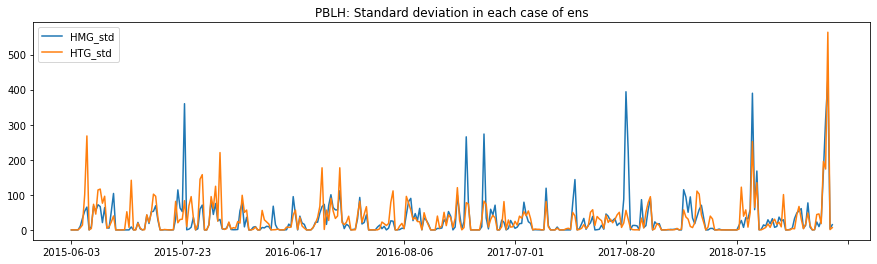

In [57]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(np.arange(len(hmg_std.year_month_day.values)), np.squeeze(hmg_std.values), label='HMG_std')
axs.plot(np.arange(len(htg_std.year_month_day.values)), np.squeeze(htg_std.values), label='HTG_std')

axs.legend()
axs.set_title('PBLH: Standard deviation in each case of ens')

# Control tick labels
xTicks       = axs.get_xticks()
dates_xticks = strDates[xTicks.astype(int)[:-2]]
axs.set_xticklabels(dates_xticks)



[Text(-50.0, 0, '2018-07-09'),
 Text(0.0, 0, '2015-06-03'),
 Text(50.0, 0, '2015-07-23'),
 Text(100.0, 0, '2016-06-17'),
 Text(150.0, 0, '2016-08-06'),
 Text(200.0, 0, '2017-07-01'),
 Text(250.0, 0, '2017-08-20'),
 Text(300.0, 0, '2018-07-15'),
 Text(350.0, 0, ''),
 Text(400.0, 0, '')]

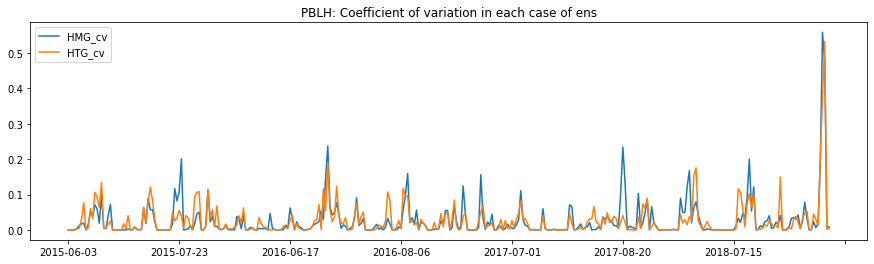

In [60]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(np.arange(len(hmg_std.year_month_day.values)), np.squeeze(hmg_cv), label='HMG_cv')
axs.plot(np.arange(len(htg_std.year_month_day.values)), np.squeeze(htg_cv), label='HTG_cv')

axs.legend()
axs.set_title('PBLH: Coefficient of variation in each case of ens')

# Control tick labels
xTicks       = axs.get_xticks()
dates_xticks = strDates[xTicks.astype(int)[:-2]]
axs.set_xticklabels(dates_xticks)



[Text(-50.0, 0, '2018-07-09'),
 Text(0.0, 0, '2015-06-03'),
 Text(50.0, 0, '2015-07-23'),
 Text(100.0, 0, '2016-06-17'),
 Text(150.0, 0, '2016-08-06'),
 Text(200.0, 0, '2017-07-01'),
 Text(250.0, 0, '2017-08-20'),
 Text(300.0, 0, '2018-07-15'),
 Text(350.0, 0, ''),
 Text(400.0, 0, '')]

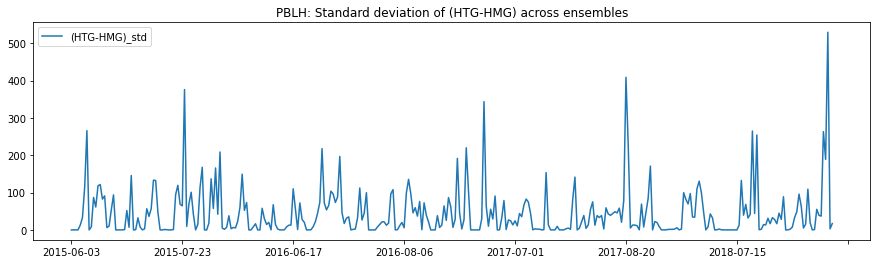

In [61]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(np.arange(len(htg_std.year_month_day.values)), np.squeeze(diff_std), label='(HTG-HMG)_std')

axs.legend()
axs.set_title('PBLH: Standard deviation of (HTG-HMG) across ensembles')

# Control tick labels
xTicks       = axs.get_xticks()
dates_xticks = strDates[xTicks.astype(int)[:-2]]
axs.set_xticklabels(dates_xticks)


(-50.0, 50.0)

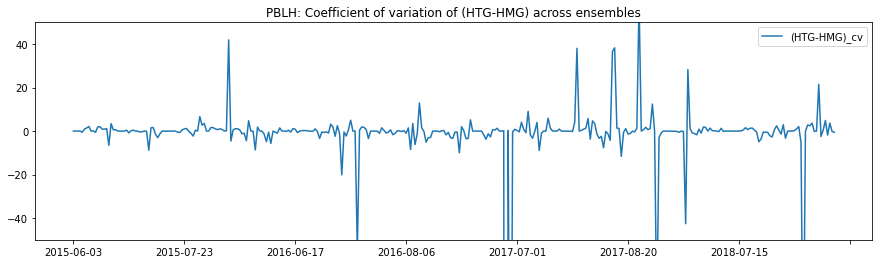

In [63]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(np.arange(len(htg_std.year_month_day.values)), np.squeeze(diff_cv), label='(HTG-HMG)_cv')
axs.legend()
axs.set_title('PBLH: Coefficient of variation of (HTG-HMG) across ensembles')

# Control tick labels
xTicks       = axs.get_xticks()
dates_xticks = strDates[xTicks.astype(int)[:-2]]
axs.set_xticklabels(dates_xticks)

axs.set_ylim([-50,50])

In [75]:
threshold = 0.25
check_cv  = np.where( (diff_cv>=-threshold) & (diff_cv<=threshold) )[0]

print('How many days are within %i pct of the mean %s difference? [12-6p mean]' % ((threshold*100), varSel))
print('Total days in record: %i\nNum days selected: %i' % (len(np.squeeze(diff_cv)), len(check_cv) ) )
print('Pct of days captured: ', (len(check_cv)/len(np.squeeze(diff_cv)))*100)


How many days are within 25 pct of the mean PBLH difference? [12-6p mean]
Total days in record: 344
Num days selected: 118
Pct of days captured:  34.30232558139535


In [83]:
check_cv_diff  = np.where( (diff_cv>=-threshold) & (diff_cv<=threshold) & (np.abs(diff_mean)>=100.0) )[0]
print('Number of days within CV threshold *and* with a dPBLH of more than +/- 100m: ', len(check_cv_diff))

Number of days within CV threshold *and* with a dPBLH of more than +/- 100m:  21


In [84]:

print('  Date       Coeff_variation (%)       Mean dPBLH')
for iDays in range(len(check_cv_diff)):
    print(htg_std.year_month_day.values[check_cv_diff[iDays]],'  %12.4f %14.3f   ' % ( diff_cv.values[check_cv_diff[iDays]]*100, diff_mean.values[check_cv_diff[iDays]]) )


  Date       Coeff_variation (%)       Mean dPBLH
(2015, 6, 26)        -0.0283       -412.971   
(2015, 7, 16)        -0.3399       -170.999   
(2015, 7, 17)         0.0032        558.737   
(2015, 7, 25)        -9.1165       -102.630   
(2015, 8, 3)         0.0010        199.222   
(2016, 6, 20)        22.3482        323.817   
(2016, 6, 21)        24.5814        113.993   
(2016, 6, 24)         0.0829        126.257   
(2016, 6, 27)       -16.5582       -132.678   
(2016, 8, 5)        19.1609        104.500   
(2017, 6, 25)        16.3279        194.699   
(2017, 7, 23)        -0.0346       -240.304   
(2017, 7, 25)        -4.3953       -109.790   
(2017, 8, 22)        -2.8547       -179.493   
(2018, 7, 3)        19.0412        225.328   
(2018, 7, 4)         9.5879        334.894   
(2018, 7, 15)         0.0005        374.097   
(2018, 7, 16)         8.0384        154.631   
(2018, 8, 7)        -0.0516       -335.096   
(2018, 8, 8)         1.5558        118.831   
(2018, 8, 19)   

In [82]:

print('  Date       Coeff_variation (%)       Mean dPBLH')
for iDays in range(len(check_cv)):
    print(htg_std.year_month_day.values[check_cv[iDays]],'  %12.4f %14.3f   ' % ( diff_cv.values[check_cv[iDays]]*100, diff_mean.values[check_cv[iDays]]) )


  Date       Coeff_variation (%)       Mean dPBLH
(2015, 6, 3)        -0.0157         -3.658   
(2015, 6, 4)        -0.0187        -12.153   
(2015, 6, 5)        -1.6329         -1.905   
(2015, 6, 6)         2.2875          6.237   
(2015, 6, 11)        -0.0288        -56.431   
(2015, 6, 12)         9.8106         82.147   
(2015, 6, 23)        -0.0000         -0.051   
(2015, 6, 24)        -0.0000         -0.063   
(2015, 6, 25)        -0.0000         -1.828   
(2015, 6, 26)        -0.0283       -412.971   
(2015, 6, 29)        18.8545         37.468   
(2015, 7, 1)        -0.0224        -28.150   
(2015, 7, 2)        -5.3419        -12.741   
(2015, 7, 5)         0.4555          8.559   
(2015, 7, 6)        -7.9641        -34.060   
(2015, 7, 13)         0.0320          0.995   
(2015, 7, 14)        -0.0155        -29.100   
(2015, 7, 15)        -6.0665        -19.195   
(2015, 7, 16)        -0.3399       -170.999   
(2015, 7, 17)         0.0032        558.737   
(2015, 7, 18)     

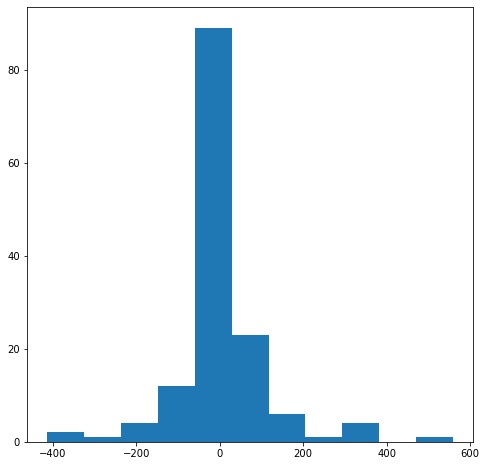

90th percentile of dPBLH on selected days:  102.07347564697262
10th percentile of dPBLH on selected days:  -70.12987518310547
Number of days in 90th percentile:  15
Number of days in 10th percentile:  15


In [68]:
fig,axs = plt.subplots(1,1,figsize=(8,8))

diffMean_similarDays = diff_mean[check_cv]

axs.hist(np.squeeze(diffMean_similarDays), bins=int(np.sqrt(len(check_cv))))
plt.show()

axs.set_title('Distribution of 12-6p mean dPBLH, only on days with similar differences')

print('90th percentile of dPBLH on selected days: ', np.nanpercentile(diffMean_similarDays, 90))
print('10th percentile of dPBLH on selected days: ', np.nanpercentile(diffMean_similarDays, 10))

print('Number of days in 90th percentile: ', len(np.where(diffMean_similarDays >= np.nanpercentile(diffMean_similarDays, 90))[0]) )
print('Number of days in 10th percentile: ', len(np.where(diffMean_similarDays <= np.nanpercentile(diffMean_similarDays, 10))[0]) )
